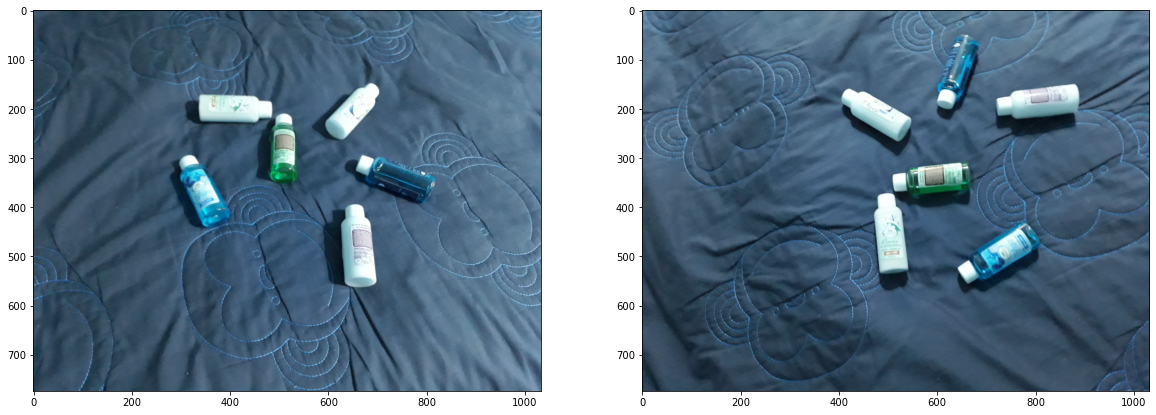

OpenCV results


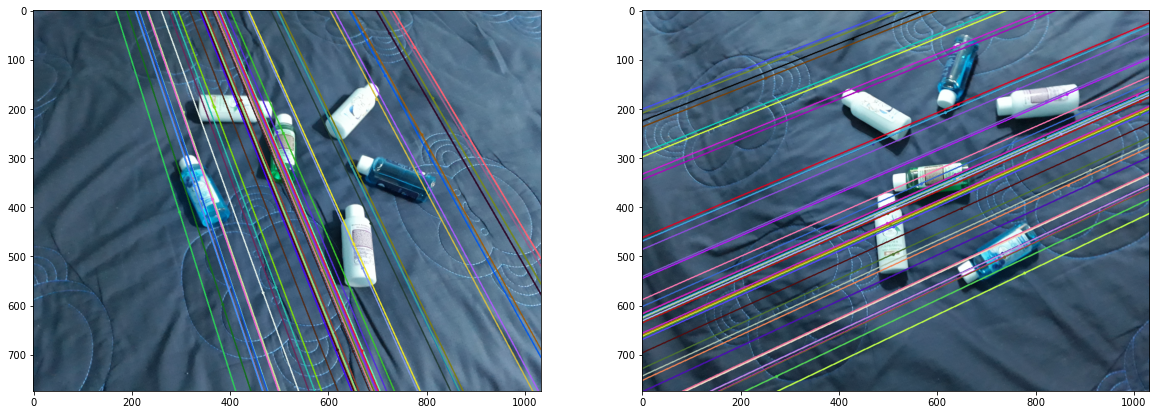

F
[[ 3.58468770e-08 -2.27998171e-07 -4.38385672e-04]
 [-2.63545492e-07 -3.70146241e-07 -8.59678183e-04]
 [-1.07966592e-03  7.50129831e-04  1.00000000e+00]]
E
[[ 0.02457605 -0.1563119  -0.42072665]
 [-0.18068257 -0.25376634 -0.943021  ]
 [-0.96309734  0.40508756  0.03024084]]
Rank of E
2
s
[1.08518969e+00 1.05038599e+00 4.09290931e-16]
R
[[-0.05757027  0.93381451 -0.35309507]
 [-0.98224349  0.01027708  0.18732888]
 [ 0.17855922  0.35760991  0.91664157]]
det(R)
1.0000000000000002
t
[ 1.03299079 -0.01239983 -0.33228441]
Our results


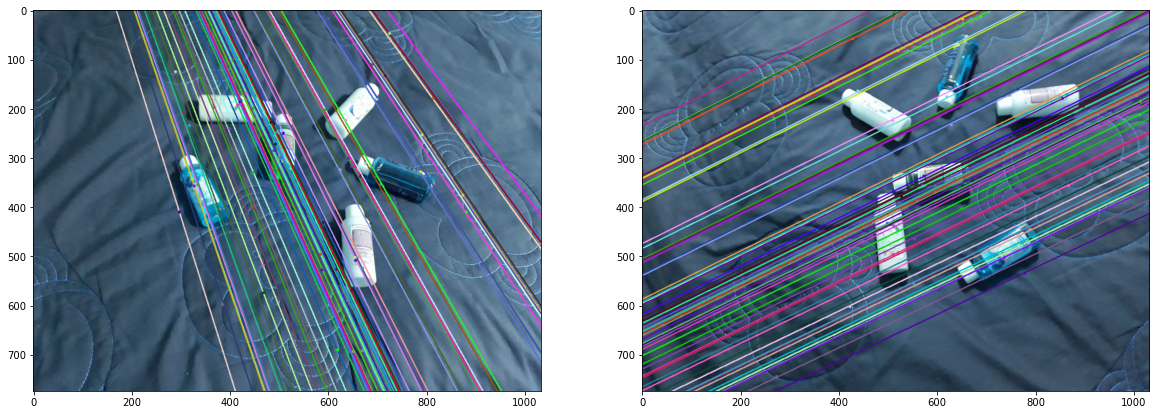

F
[[-1.67381978e-07 -2.91589945e-07 -4.04692403e-04]
 [-2.30596548e-07 -6.50659438e-07 -8.70922142e-04]
 [-1.05281323e-03  9.82316727e-04  1.00000000e+00]]
E
[[-0.11475441 -0.1999094  -0.50003484]
 [-0.1580933  -0.4460817  -1.02814016]
 [-1.0171344   0.48028232  0.04474527]]
Rank of E
2
s
[1.26761743e+00 1.11561796e+00 2.95496536e-16]
R
[[ 0.72879591  0.55159484 -0.40570883]
 [ 0.65706533 -0.73009151  0.18770068]
 [-0.19266985 -0.40337269 -0.89452155]]
det(R)
1.000000000000002
t
[ 1.11624443 -0.28543899  0.52856116]
After Magic


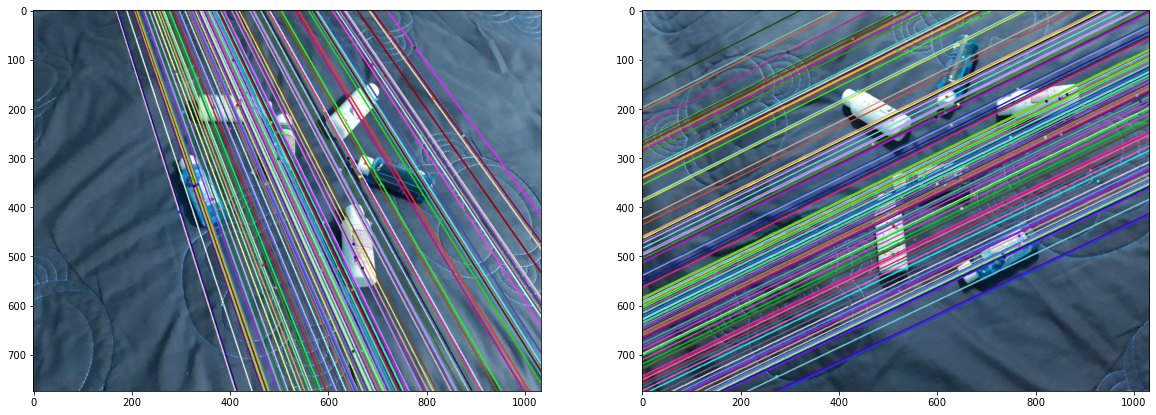

F
[[-1.84708096e-07 -2.65141133e-07 -3.75290628e-04]
 [-2.58722642e-07 -5.97901419e-07 -8.10827638e-04]
 [-1.11363791e-03  9.64040308e-04  9.63322439e-01]]
E
[[-0.12663292 -0.18177652 -0.47461757]
 [-0.1773761  -0.40991165 -0.97349316]
 [-1.0839124   0.49335522  0.01099047]]
Rank of E
2
[1.19161769e+00 1.19161769e+00 3.21246356e-17]
s
R
[[-0.05867106  0.93737129 -0.34335518]
 [-0.98405825  0.00353827  0.17781126]
 [ 0.16789005  0.34831387  0.92222035]]
det(R)
0.9999999999999983
t
[ 0.19976732  1.06450203 -0.49687139]


In [1]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import null_space

def detectAndDescribe(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
def matchKeypoints(kps1, kps2, features1, features2, ratio=0.75):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(features1, features2, 2)
        pts1_ = []
        pts2_ = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                pts1_.append(m[0].trainIdx)
                pts2_.append(m[0].queryIdx)
        pts1 = np.float32([kps1[i] for i in pts2_])
        pts2 = np.float32([kps2[i] for i in pts1_])
        return (pts1, pts2)

def draw(img, pts):
    _, c, _ = img.shape
    for pt in pts:
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img = cv2.circle(img, tuple(pt), 5, color, -1)
    return img
    
def drawlines(image1, image2, lines, pts1, pts2):
    _, c, _ = image1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
        image1 = cv2.circle(image1, tuple(pt1), 3, color, -1)
        image2 = cv2.circle(image2, tuple(pt2), 3, color, -1)
        image1 = cv2.line(image1, (x0, y0), (x1, y1), color, 2)
    return image1

K1 = np.array([[24107, 0,     2064],
               [0,     24107, 1548],
               [0,     0,     1]])

K2 = np.array([[3312,  0,     2064],
               [0,     3312,  1548],
               [0,     0,     1]])

Tr = np.array([[1,  0,  -2064],
               [0,  1,  -1548],
               [0,  0,  1]])

#######################################################################
    
def get_fundamental(pts1, pts2):
    X = []
    for i in range(7):
        vec = np.matmul([[pts1[i][0]], [pts1[i][1]], [1]],
                        [[pts2[i][0], pts2[i][1], 1]]).flatten()
        X.append(list(vec))
    F = null_space(X)
    F = F.T
    F1 = F[0]
    F1 = F1.reshape((3, 3))
    F1 /= F1[2][2]
    F2 = F[1]
    F2 = F2.reshape((3, 3))
    F2 /= F2[2][2]
    answer = []
    if np.linalg.matrix_rank(F1) == 2:
        answer.append(F1)
    if np.linalg.matrix_rank(F2) == 2:
        answer.append(F2)
    if len(answer) > 0:
        return answer
    if np.linalg.matrix_rank(F1) < 2:
        return []
    if np.linalg.matrix_rank(F2) < 2:
        return []

    c1 = np.matmul(F2, np.linalg.inv(F1))
    c2 = np.matmul(F1, np.linalg.inv(F2))
    coeff = [np.linalg.det(F1),
             np.linalg.det(F1) * np.trace(c1),
             np.linalg.det(F2) * np.trace(c2),
             np.linalg.det(F2)]
    gammas = np.roots(coeff)
    gamma = [g for g in gammas if np.isreal(g)]
    answer = [(np.real(g) * F1 + F2) for g in gamma]
    answer = [a/a[2][2] for a in answer]
    return answer

def mod(x1, x2):
    return ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2 + (x1[2] - x2[2])**2)**0.5

def Gain(F, pts1, pts2, epsilon=10, show=0):
    result = 0
    F /= F[2][2]
    M = np.zeros((len(pts1)), np.int)
    for i in range(len(pts1)):
        c = np.matmul([pts1[i][0], pts1[i][1], 1], F)
        a = np.matmul(c, [[pts2[i][0]], [pts2[i][1]], [1]])[0]
        
        b = (c[0]**2 + c[1]**2)**0.5
        inc = int(abs(a / b) <= epsilon)
        if show == 1:
            print(a / b)
        result += inc
        M[i] = inc
    return result, M

def pick_random_7(pts1, pts2):
    rand_perm = np.random.permutation(len(pts1))
    pts1_ = []
    pts2_ = []
    for i in range(7):
        pts1_.append(pts1[rand_perm[i]])
        pts2_.append(pts2[rand_perm[i]])
    return pts1_, pts2_

def RANSAC(pts1, pts2, epsilon=10):
    F_best = np.zeros((3, 3), np.float32)
    Gain_best = -1
    M_best = np.zeros((len(pts1)), np.int)
    iterations = 10000
    while iterations > 0:
        pts1_, pts2_ = pick_random_7(pts1, pts2)
        F_cur = get_fundamental(pts1_, pts2_)
        if len(F_cur) > 0:
            for F_c in F_cur:
                Gain_cur, M_cur = Gain(F_c, pts1, pts2, epsilon)
                if Gain_cur > Gain_best:
                    Gain_best = Gain_cur
                    F_best = F_c
                    M_best = M_cur
        iterations -= 1
    return F_best, M_best

def Magic(u, s_, vh):
    s = s_.copy()
    s[1] = (s[0] + s[1]) / 2
    s[0] = s[1]
    s[2] = 0
    S = [[s[0], 0, 0],
         [0, s[1], 0],
         [0, 0, s[2]]]
    E = np.dot(np.dot(u, S), vh)
    F = np.dot(np.dot(np.linalg.inv(K2.T), E), np.linalg.inv(K2))
    return E, F

def Restore(u, s, vh):
    w = np.dot(u, [[0,  1,  0],
                   [-1, 0,  0],
                   [0,  0,  1]])
    R = np.linalg.det(w) * np.linalg.det(vh.T) * np.dot(w, np.linalg.inv(vh.T))
    t = s[0] * np.linalg.det(w) * vh.T[2]
    K = np.array([[0, -t[2], t[1]],
                  [t[2], 0, -t[0]],
                  [-t[1], t[0], 0]])
    return R, t

nameA = "1"
nameB = "2"
sufix = ".jpg"

imageA = cv2.imread(nameA + sufix)
imageB = cv2.imread(nameB + sufix)

scale = 4

h, w, _ = imageA.shape
imageA = imutils.resize(imageA, width=int(w / scale))
imageB = imutils.resize(imageB, width=int(w / scale))
h, w, _ = imageA.shape
K1 = K1 / scale
K1[2][2] = 1
K2 = K2 / scale
K2[2][2] = 1
Tr[0][2] /= scale
Tr[1][2] /= scale

imageA_ = imageA.copy()
imageB_ = imageB.copy()

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA)
plt.subplot(122), plt.imshow(imageB)
plt.show()

(kpsA, featuresA) = detectAndDescribe(imageA)
(kpsB, featuresB) = detectAndDescribe(imageB)

(ptsA, ptsB) = matchKeypoints(kpsA, kpsB, featuresA, featuresB, 0.80)
ptsA = np.int32(ptsA)
ptsB = np.int32(ptsB)

pA = np.zeros((len(ptsA), 3))
pB = np.zeros((len(ptsB), 3))

for i in range(len(ptsA)):
    pA[i] = np.dot(Tr, [[ptsA[i][0]], [ptsA[i][1]], [1]])[0]
    pB[i] = np.dot(Tr, [[ptsB[i][0]], [ptsB[i][1]], [1]])[0]

###############################################################

print("OpenCV results")

F, mask = cv2.findFundamentalMat(ptsA, ptsB, cv2.FM_RANSAC, 1, 0.99)
ptsA_ = ptsA[mask.ravel()==1]
ptsB_ = ptsB[mask.ravel()==1]

lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA.copy(), imageB.copy(), lines1, ptsA_, ptsB_)

lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB.copy(), imageA.copy(), lines2, ptsB_, ptsA_)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("res_cv_" + nameA + ".jpg", imageA1) 
cv2.imwrite("res_cv_" + nameB + ".jpg", imageA2)

print("F")
print(F)
E = np.dot(np.dot(K2.T, F), K2)
print("E")
print(E)
print("Rank of E")
print(np.linalg.matrix_rank(E))

u, s, vh = np.linalg.svd(E)
print("s")
print(s)

R, t = Restore(u, s, vh)
print("R")
print(R)
print("det(R)")
print(np.linalg.det(R))
print("t")
print(t)

print("Our results")

F, M = RANSAC(ptsB, ptsA, 3)
F /= F[2][2]
ptsA_ = ptsA[M==1]
ptsB_ = ptsB[M==1]

lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA, imageB, lines1, ptsA_, ptsB_)

lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB, imageA, lines2, ptsB_, ptsA_)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("res_" + nameA + ".jpg", imageA1) 
cv2.imwrite("res_" + nameB + ".jpg", imageA2)

print("F")
print(F)

E = np.matmul(np.matmul(K2.T, F), K2)
print("E")
print(E)

print("Rank of E")
print(np.linalg.matrix_rank(E))

u, s, vh = np.linalg.svd(E)
print("s")
print(s)

R, t = Restore(u, s, vh)
print("R")
print(R)
print("det(R)")
print(np.linalg.det(R))
print("t")
print(t)

print("After Magic")

E, F = Magic(u, s, vh)

lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA, imageB, lines1, ptsA_, ptsB_)

lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB, imageA, lines2, ptsB_, ptsA_)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("res_refined_" + nameA + ".jpg", imageA1) 
cv2.imwrite("res_refined_" + nameB + ".jpg", imageA2)

print("F")
print(F)
print("E")
print(E)

print("Rank of E")
print(np.linalg.matrix_rank(E))

u, s, vh = np.linalg.svd(E)
print(s)
print("s")

R, t = Restore(u, s, vh)
print("R")
print(R)
print("det(R)")
print(np.linalg.det(R))
print("t")
print(t)